In [1]:
# Samuel Grant 2024

## Read failure events and make plots. 

### Based on PlotFailures.py. Better suited to notebook (so we don't have to load the data each time). 

In [55]:
# External libraries
import numpy as np
import pandas as pd
import awkward as ak
import uproot
import matplotlib.pyplot as plt

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
import PrintUtils as pr

In [56]:
from statsmodels.stats.proportion import proportion_confint
def WilsonUncertainty(data_, conservative=True):
    # What happens if the number of failures gets close to zero?
    k = np.sum(data_["Failures"])
    N = np.sum(data_["Total"])
    lower, upper = proportion_confint(k, N, method="wilson")
    point = k/N
    if conservative: 
        return abs((upper - point) / 2)
    else:
        return abs((lower - point) / 2)

In [57]:
# Parameters
PEs=10
layers="3"
particle="all"
dataset="MDC2020ae"

In [58]:
# Persistent failure info; useful to know. |
inDir=f"../Txt/{dataset}/Summer24/SeventhPass/concatenated"
trigger="crv_trigger"
failureFilePath = f"{inDir}/failures_concise/failures_concise_all_{PEs}PEs{layers}Layers_{trigger}.csv"

print(f"\n---> Using info file {failureFilePath}.")
failureInfo_ = pd.read_csv(failureFilePath)
print(failureInfo_)
print()

# Results info; useful to know. 
resultsFilePath = f"{inDir}/results/results_all_{PEs}PEs{layers}Layers_{trigger}.csv"
print(f"\n---> Using info file {resultsFilePath}.")
results_ = pd.read_csv(resultsFilePath)
print(results_)

ineff = np.sum(results_["Failures"])/np.sum(results_["Total"])
ineffErr = WilsonUncertainty(results_)

# Start output string 
resultStr = f"""
**********************************
Trigger: {trigger}
PEs: {PEs}
layers: {layers}/4
particle: {particle}

Failures: {np.sum(results_["Failures"])}
Total: {np.sum(results_["Total"])}

Inefficiency = {ineff*100:.5f}+/-{ineffErr*100:.5f}%
**********************************
"""
# {np.sum(resultsNoTrackCuts_["Failures"])}/{np.sum(resultsNoTrackCuts_["Total"])} = {ineffNoTrackCuts*100:.5f}%
# Track cuts: {np.sum(resultsTrackCuts_["Failures"])}/{np.sum(resultsTrackCuts_["Total"])} = {ineffTrackCuts*100:.5f}%

print(resultStr)


---> Using info file ../Txt/MDC2020ae/Summer24/SeventhPass/concatenated/failures_concise/failures_concise_all_10PEs3Layers_crv_trigger.csv.
                tag  evtinfo.run  evtinfo.subrun  evtinfo.event
0   001205_00000009         1205            1047         430226
1   001205_00000014         1205            6544         282227
2   001205_00000015         1205            5730          12409
3   001205_00000015         1205            9716         114594
4   001205_00000016         1205            3118         422170
5   001205_00000016         1205            6413          66312
6   001205_00000019         1205              19         454961
7   001205_00000019         1205             827         326820
8   001205_00000020         1205            2263         473431
9   001205_00000024         1205            6549         110979
10  001205_00000025         1205            6734          49366
11  001205_00000028         1205            9374         378962
12  001205_00000031        

In [59]:
# Inspect a failure (also in TrackCuts)
# tag="001205_00000020"
run=1205
subrun=299 # 2263
event=79434 # 473431
filename="/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00023/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000000.root" #/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00069/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000020.root"
with uproot.open(filename) as file:
    print(file)
    array_ = ut.GetData(file)
    print(array_)
    print(array_["evt"]["evtinfo.event"])
    # runCondition = ak.any(array_["evt"]["evtinfo.run"] == run, axis=0)
    # subrunCondition = ak.any(array_["evt"]["evtinfo.subrun"] == subrun, axis=0)
    # eventCondition = ak.any(array_["evt"]["evtinfo.event"] == event, axis=0)
    runCondition = array_["evt"]["evtinfo.run"] == run
    subrunCondition = array_["evt"]["evtinfo.subrun"] == subrun
    eventCondition = array_["evt"]["evtinfo.event"] == event
    array_ = array_[runCondition & subrunCondition & eventCondition] 
    # pr.PrintNEvents(array_, masks_=[")

<ReadOnlyDirectory '/' at 0x7f4a905d2ba0>
[{evt: {'evtinfo.run': 1205, ...}, crv: {...}, trk: {...}, ...}, ..., {...}]
[331, 379, 759, 891, 1432, 2430, ..., 498161, 499019, 499859, 499895, 499971]


In [7]:
# Internal libraries
# sys.path.append(os.path.abspath("../PyMacros"))
# import Utils as ut
# import PrintUtils as pr
# %run PlotFitUtils.ipynb
# from Mu2eEAF import ReadData as rd 

In [62]:
'''
Get failure info
For each file, collect the events. 

This takes quite a while (2-3 minutes maybe).
'''
def GetFailures(fileList_, PEs=10, layers="3", particle="all", cut="track_cuts", inDir="../Txt/MDC2020ae/concatenated", n=-1):

    # fileList_ = fileList_[:n]
    
    # Collect failure info
    # inDir="../Txt/MDC2020ae/concatenated"
    failureFilePath = f"{inDir}/failures_concise/failures_concise_{particle}_{PEs}PEs{layers}Layers_{cut}.csv"

    print(f"\n---> Using info file {failureFilePath}.")
    failureInfo_ = pd.read_csv(failureFilePath)

    if failureInfo_.empty:
        print("---> No failure info.")
        dummy_ = {}
        for field, branches_ in ut.allBranchNames_.items():
            dummy_[field] = ak.zip({name: ak.Array([]) for name in branches_})
        return ak.zip(dummy_)

    # Collect file list
    tags_ = list(set(failureInfo_["tag"]))
    # tags_ = tags_[:n]
    
    # Extract the tag from the file name
    def ExtractTag(fileName):
        parts = fileName.split('.')
        if len(parts) > 1:
            return parts[-2]
        return None

    # Filter and sort files based on tags
    fileList_ = sorted(
        [file for file in fileList_ if ExtractTag(file) in tags_]
        , key=lambda file: tags_.index(ExtractTag(file))
    )

    # Bug check
    if len(fileList_) == len(tags_):
        print("\n---> Collected and sorted failure file names.")
    else:
        print("Warning: len(fileList_) != len(tags_)... adjusting.")
        tags_ = tags_[:len(fileList_)]
        # raise Exception("\n---> len(fileList_) != len(tags_)")

    completedFiles = 0
    totalFiles = len(fileList_)

    print(f"\n---> Iterating through {len(fileList_)} files.\n") 

    # Master array to hold results
    data_ = ak.Array([])
    
    # Iterate through file list.
    for tag, fileName in zip(tags_, fileList_): 
    
        # Find failure events
        thisFailureInfo_ = failureInfo_[failureInfo_["tag"] == tag]
        outputStr = ( 
            f"\n--->\n" 
            f"fileName: {fileName}\n"
            f"tag: {tag}\n"
            f"failures:\n{thisFailureInfo_}\n"
            f"---"
        )
        if False: print(outputStr)
    
        # Read the file
        with uproot.open(fileName) as file: 
            
            # file = (fileName, quiet=True)
            # Get array
            thisData_ = ut.GetData(file)
        
            if False: print(f"\n---> Loaded corresponding data.\n{thisData_}")
                
            if False: print(f"\n---> Applying masks.")
        
            # Extract unique values from DataFrame
            runs_ = set(thisFailureInfo_["evtinfo.run"])
            subruns_ = set(thisFailureInfo_["evtinfo.subrun"])
            events_ = set(thisFailureInfo_["evtinfo.event"])
        
            # Construct masks
            runCondition = ak.any([thisData_["evt"]["evtinfo.run"] == value for value in runs_], axis=0)
            subrunCondition = ak.any([thisData_["evt"]["evtinfo.subrun"] == value for value in subruns_], axis=0)
            eventCondition = ak.any([thisData_["evt"]["evtinfo.event"] == value for value in events_], axis=0)
        
            # Apply masks
            thisData_ = thisData_[runCondition & subrunCondition & eventCondition]
        
            # Append to master array
            if False: print(f"\n---> Appending failures to master array.")
            data_ = ak.concatenate([data_, thisData_], axis=0)

            if False:
                print(thisFailureInfo_)
                ut.PrintNEvents(data_)
    
            completedFiles += 1
            percentComplete = (completedFiles / totalFiles) * 100
            
            print(f"\r---> Processed {fileName} ({percentComplete:.1f}% complete...)", end="") 

            # print("BREAKING")
            # break

    inputEventList = failureInfo_["evtinfo.event"]
    outputEventList = ak.flatten(data_["evt"]["evtinfo.event"], axis=None)

    return data_

In [63]:
# Get file list
fileListPath="../Txt/FileLists/MDC2020aeOnExpData.txt"
def ReadFileList(fileListPath):
  with open(fileListPath, "r") as fileList_:
    lines = fileList_.readlines()
    lines = [line.strip() for line in lines]  # Remove leading/trailing whitespace
  return lines
fileList_=ReadFileList(fileListPath)
print(f"---> {len(fileList_)} files in list.")

---> 96 files in list.


In [64]:
failures_crv_trigger_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="crv_trigger", inDir=f"../Txt/{dataset}/Summer24/SeventhPass/concatenated/")


---> Using info file ../Txt/MDC2020ae/Summer24/SeventhPass/concatenated//failures_concise/failures_concise_all_10PEs3Layers_crv_trigger.csv.

---> Collected and sorted failure file names.

---> Iterating through 36 files.

---> Processed /exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00029/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000171.root (100.0% complete...)

In [68]:
failures_trk_crv2_2layers_trigger_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="trk_crv2_2layers_trigger", inDir=f"../Txt/{dataset}/Summer24/SeventhPass/concatenated/")


---> Using info file ../Txt/MDC2020ae/Summer24/SeventhPass/concatenated//failures_concise/failures_concise_all_10PEs3Layers_trk_crv2_2layers_trigger.csv.

---> Collected and sorted failure file names.

---> Iterating through 14 files.

---> Processed /exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00073/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000037.root (100.0% complete...)

In [74]:
def BarChart(data_, label_dict, title=None, xlabel=None, ylabel=None, fout="bar_chart.png", percentage=False, bar_alpha=1.0, bar_color='black', NDPI=300):
    
    # This came from ChatGPT
    # it matches the key of the dict with row in the data array and returns the element as the label
    labels = [label_dict.get(p, 'other') for p in data_]

    # Count occurrences of each label
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Only works for particles 

    # Sort labels and counts in descending order
    sorted_indices = np.argsort(label_counts)[::-1]
    unique_labels = unique_labels[sorted_indices]
    label_counts = label_counts[sorted_indices]

    if percentage: 
        label_counts = (label_counts / np.sum(label_counts))*100

    # Create figure and axes
    fig, ax = plt.subplots()

    # print(unique_labels)

    indices = np.arange(len(unique_labels))

    # print(indices)
    # for i, index in enumerate(indices):
    #     indices[i] = GetLatexParticleName(index)

    # TODO: handle this better
    n_bars = len(indices)
    bar_width = 1.0
    if n_bars > 0:
        bar_width = 3.0 / n_bars
        if(n_bars == 3.0): 
            bar_width = 2.0 / n_bars
        elif(n_bars == 2.0):
            bar_width = 1.0 / n_bars

    ax.bar(indices, label_counts, align='center', alpha=bar_alpha, color=bar_color, width=bar_width, fill=False, hatch='/', linewidth=1, edgecolor='black')

    # Set x-axis labels
    ax.set_xticks(indices)
    ax.set_xticklabels(unique_labels, rotation=0) # 45)

    # Set labels for the chart
    ax.set_title(title, fontsize=16, pad=10)
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=14)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=14)  # Set y-axis tick label font size

    # Scientific notation
    ut.ScientificNotation(ax)
    # if ax.get_xlim()[1] > 999:
    #     ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    #     ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    #     ax.xaxis.offsetText.set_fontsize(14)
    # if ax.get_ylim()[1] > 999:
    #     ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    #     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #     ax.yaxis.offsetText.set_fontsize(14)

    # ax.legend(loc="best", frameon=False, fontsize=14)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()
    
    print("---> Written", fout)

    # Clear memory
    plt.close()

[-11, 11, 2212, -211]


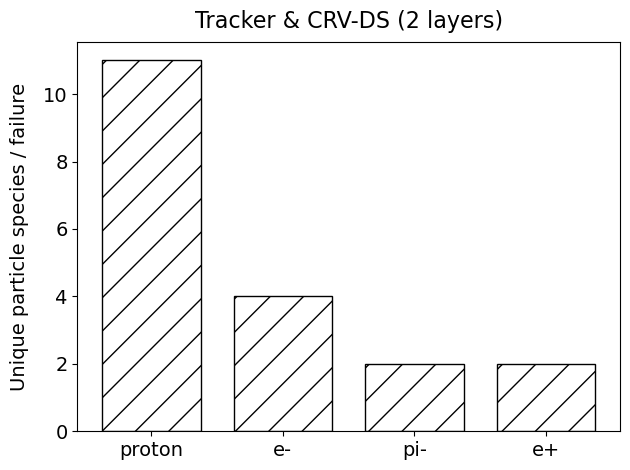

---> Written ../Images/MDC2020ae/Failures/SeventhPass/bar_pdgid_trk_crv2_2layers_trigger.png


In [75]:
print(list(set(ak.flatten(failures_trk_crv2_2layers_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}


BarChart(ak.flatten(failures_trk_crv2_2layers_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"Tracker & CRV-DS (2 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/SeventhPass/bar_pdgid_trk_crv2_2layers_trigger.png", percentage=False)

IndexError: list index out of range

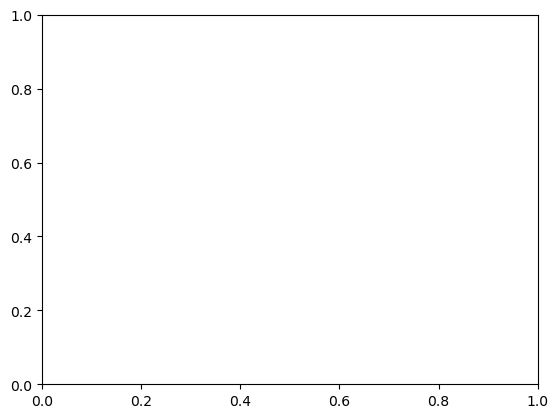

In [80]:
BarChartOverlay( { "CRV (2/4 layers)" : ak.flatten(failures_crv_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None) , 
                 "Tracker & CRV-DS (2/2)" : ak.flatten(failures_trk_crv2_2layers_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None) , }
              , label_dict=particle_dict, fout=f"../Images/MDC2020ae/Failures/SeventhPass/bar_pdgid_partial_overlay.png")

In [42]:
def Plot1D(data, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, fout="hist.png", legPos="best", log=False, stats=True, underOver=False, errors=False, NDPI=300):
    
    data = np.array(data)
    # data = np.flatten(data)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot the histogram with outline
    counts, bin_edges, _ = ax.hist(data, bins=nbins, range=(xmin, xmax), histtype='step', edgecolor='black', linewidth=1.0, fill=False, density=False)

    # Log scale 
    if log:
        ax.set_yscale('log')
        
    # Set x-axis limits
    ax.set_xlim(xmin, xmax)

    # Calculate statistics
    N, mean, meanErr, stdDev, stdDevErr, underflows, overflows = ut.GetBasicStats(data, xmin, xmax)

    # # Create legend text
    legendText = f"Entries: {N}\nMean: {ut.Round(mean, 3)}\nStd Dev: {ut.Round(stdDev, 3)}"
    if errors: legendText = f"Entries: {N}\nMean: {ut.Round(mean, 3)}" + r"$\pm$" + f"{ut.Round(meanErr, 1)}\nStd Dev: {ut.Round(stdDev, 3)}" + r"$\pm$" + f"{ut.Round(stdDevErr, 1)}"
    if underOver: legendText += f"\nUnderflows: {underflows}\nOverflows: {overflows}"

    # Add legend to the plot
    if stats: ax.legend([legendText], loc=legPos, frameon=False, fontsize=13)

    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

    ut.ScientificNotation(ax)
    # if (ax.get_ylim()[1] > 9.999e3) or (ax.get_ylim()[1] < 9.999e-2):
    #             ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    #             ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #             ax.yaxis.offsetText.set_fontsize(14)
    
    # if (ax.get_ylim()[1] > 9.999e2) or (ax.get_ylim()[1] < 9.999e-2):
    #         ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    #         ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #         ax.yaxis.offsetText.set_fontsize(14)

    # plt.ticklabel_format(useOffset=False)
    
    # plt.ticklabel_format(axis='y', style='plain', useOffset=False)

    plt.tight_layout()

    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()

    print("\n---> Written:\n\t", fout)

    # Clear memory
    plt.close()

    return

In [79]:
def BarChartOverlay(data_, label_dict, title=None, xlabel=None, ylabel=None, fout="bar_chart.png", percentage=False, bar_alpha=1.0, NDPI=300):

    # Initialize figure and axis
    fig, ax = plt.subplots()

    # Initialize variables for bar width calculation
    n_data_sets = len(data_)
    bar_width = 0.5 / n_data_sets

    # Get unique labels from the label dictionary
    unique_labels = list(label_dict.values())

    for i, (label, dataset) in enumerate(data_):
    
        labels = [label_dict.get(p, 'other') for p in dataset]
        unique_labels_data, label_counts_data = np.unique(labels, return_counts=True)

        # Reorder label counts based on unique_labels
        label_counts = [label_counts_data[unique_labels_data == label][0] if label in unique_labels_data else 0 for label in unique_labels]

        if percentage:
            label_counts = (np.array(label_counts) / sum(label_counts)) * 100

        # Calculate the position of bars
        indices = np.arange(len(unique_labels)) + i * bar_width

        # Plot the bar chart for the current dataset
        # ax.bar(indices, label_counts, align='center', alpha=bar_alpha, color=colours[i+1], edgecolor=colours[i+1], width=bar_width, fill=False, hatch='/', linewidth=1, label=label_[i])
        ax.bar(indices, label_counts, align='center', alpha=bar_alpha, color=ut.colours[i+1], edgecolor=ut.colours[i+1], width=bar_width, linewidth=1, label=label_[i])

    # Set x-axis labels
    ax.set_xticks(indices - bar_width * (n_data_sets - 1) / 2)
    ax.set_xticklabels(unique_labels, rotation=0)

    # Set labels for the chart
    ax.set_title(title, fontsize=16, pad=10)
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Set scientific notation for y-axis if necessary
    ScientificNotation(ax)

    # Add legend
    ax.legend(loc="best", frameon=False, fontsize=14)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()
    
    print("---> Written", fout)

    # Clear memory
    plt.close()

    return

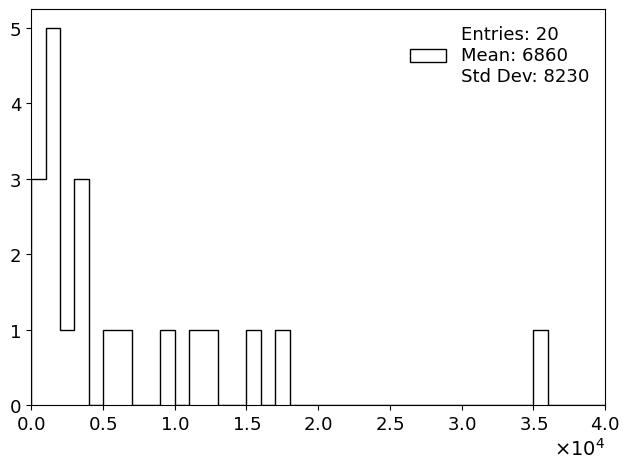


---> Written:
	 ../Images/MDC2020ae/Failures/SeventhPass/h1_trk_trigger_muon_primaryE.png


In [52]:
# # Plot1DOverlay( { "CRV trigger failures" : ak.flatten(failures_crv_trigger_["crv"]["crvcoincsmc.primaryE"], axis=None) , 
# #                  "Tracker trigger failures" : ak.flatten(failures_trk_trigger_["crv"]["crvcoincsmc.primaryE"], axis=None) , }
# #               , nbins=100, xmin=0, xmax=1e5, fout=f"../Images/MDC2020ae/Failures/SeventhPass/h1_overlay_primaryE_trk_vs_crv_trigger.png")

# trk_muon_failures = ak.flatten(failures_trk_trigger_["crv"]["crvcoincsmc.primaryE"][abs(failures_trk_trigger_["crv"]["crvcoincsmc.pdgId"])==13] , axis=None) 
# Plot1D(trk_muon_failures, nbins=40, xmin=0, xmax=4e4
#        xlbael="Primary energy [Unknown unit]", fout=f"../Images/MDC2020ae/Failures/SeventhPass/h1_trk_trigger_muon_primaryE.png")

# # What's the deal with the high energy one?

In [ ]:
print(list(set(ak.flatten(failures_crv_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}

BarChart(ak.flatten(failures_crv_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"CRV trigger (10 PEs in 3/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/SeventhPass/bar_pdgid_crv_trigger.png", percentage=False)

In [ ]:
print(list(set(ak.flatten(failures_trk_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}

BarChart(ak.flatten(failures_trk_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"Tracker trigger (10 PEs in 3/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/SeventhPass/bar_pdgid_trk_trigger.png", percentage=False)

In [ ]:
print(list(set(ak.flatten(failures_trk_trigger_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}

BarChart(ak.flatten(v["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"No track cuts ({PEs} PEs/layer, {layers}/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/SeventhPass/bar_pdgid_no_track_cuts.png", percentage=False)

In [ ]:
# failures_no_track_cuts_ = failures_track_cuts_

In [ ]:
# failures_track_cuts_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="track_cuts", inDir="../Txt/MDC2020ae/AugustCRVMeeting/FourthPass/concatenated")

In [ ]:
# failures_track_crv12_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="track_crv12")

In [ ]:
# # Plot failure info
# print(list(set(ak.flatten(failures_track_crv12_["crv"]["crvcoincsmc.pdgId"], axis=None))))

# particle_dict = {
#     -13: 'mu+',
#     13: 'mu-',
#     2212: 'proton',
#     -211: 'pi-',
#     -11: 'e+',
#     11: 'e-',
#     # "other": "other"
#     # Add more entries as needed
# }

# SimpleBarChart({"No track cuts" : len(failures_track_crv12_["evt"]["evtinfo.event"]), "Track cuts" : len(failures_track_cuts_["evt"]["evtinfo.event"]) }
#          , ylabel="Failures", fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_failures.png")


# BarChart(ak.flatten(failures_no_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)
#          , label_dict=particle_dict, title=f"No track cuts ({PEs} PEs/layer, {layers}/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_pdgid_no_tracks.png", percentage=False)

# BarChart(ak.flatten(failures_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)
#          , label_dict=particle_dict, title=f"Track cuts ({PEs} PEs/layer, {layers}/4 layers)", ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_pdgid_track_cuts.png", percentage=False)

# BarChartOverlay(data_=[ak.flatten(failures_no_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None), ak.flatten(failures_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)]
#                 , label_dict=particle_dict
#                 , ylabel="Unique particle species / failure"
#                 , title=f"{PEs} PEs/layer, {layers}/4 layers"
#                 , fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_pdgid_track_cuts_overlay.png"
#                 , percentage=False
#                 , label_= ["No track cuts", "Track cuts"])


# Plot2D(x=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#        , y=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#        , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#        , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZX_no_track_cuts.png")

# Plot2D(x=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#        , y=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#        , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
#        , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZY_no_track_cuts.png")

# Plot2D(x=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#        , y=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#        , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#        , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZX_track_cuts.png")

# Plot2D(x=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#        , y=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#        , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
#        , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZY_track_cuts.png")

In [ ]:
# # What is more interesting is those that pass the singles cut, but not the track cut.
# # Although, this good be biased a bit because sometimes the track cuts generate an exception, while the singles do not!
# # Need to ID a file where this doesn't happen. (See ../Scripts/FindGoodFiles.sh)
# # 79 good files, written tags to ../Txt/MDC2020ae/GoodFiles/good_files.csv

# goodFileTags_ = ReadFileList("../Txt/MDC2020ae/GoodFiles/good_files.csv")

# # Make a dataframe for singles and singles_track_cuts using these files. 
# def CollectGoodFiles(goodFileTags_, PEs="10", layer="3", particle="all", cut="singles"):
#     baseDir=f"../Txt/MDC2020ae/failures_concise"
#     data_ = pd.DataFrame()
#     tasks = len(goodFileTags_)
#     completedTasks = 1
#     for i, goodFileTag in enumerate(goodFileTags_):
#         if i == 0: continue # skip header
#         goodFile = f"{baseDir}/{goodFileTag}/failures_concise_{particle}_{PEs}PEs{layer}Layers_{cut}.csv"
#         thisData_ = pd.read_csv(goodFile)
#         # Append data to the main DataFrame without resetting the index
#         if thisData_ is not None: 
#             # Add the tag to the first column
#             thisData_.insert(0, "Tag", goodFileTag)
#             # Concatenate
#             data_ = pd.concat([data_, thisData_], ignore_index=True)
#         completedTasks += 1
#         percentComplete = (completedTasks / tasks) * 100
#         print(f"\r---> Processed {goodFileTag} ({percentComplete:.1f}% complete...)", end="") 
#     return data_

# data_singles_ = CollectGoodFiles(goodFileTags_, PEs=10, cut="singles")
# data_singles_track_cuts_ = CollectGoodFiles(goodFileTags_, PEs=10, cut="singles_track_cuts")

# print(f"\n---> data_singles_:\n{data_singles_}")
# print(f"\n---> data_singles_track_cuts_:\n{data_singles_track_cuts_}")

In [ ]:
# # Now find entries unique to singles_track_cuts_ 
# # Merge DataFrames with an left join to get rows unique to singles_
# # I run the singles filter before the track cuts filter. 
# # This means that some events will pass the singles filter, and then be removed by the track cuts filter.
# # These events are unique to singles. 
# # We can look at the in the event display to see what happens in these cases. 

# # We need events which pass the singles cut but are then removed by the track cuts. 
# # These are actually not present in any of the failure samples, because these just contain failures. 
# # Unfortunately I do not put any marker on the ones removed by the tracker cuts, I just through them out. 

# # Merge
# data_merged_ = pd.merge(data_singles_, data_singles_track_cuts_, how="left", indicator=True)
# # Find unique to singles events
# unique_to_singles_ = data_merged_[data_merged_['_merge'] == 'left_only']
# # Drop the _merge column
# unique_to_singles_ = unique_to_singles_.drop('_merge', axis=1)
# print(unique_to_singles_)

In [ ]:
# Run it again?